In [1]:
# Fine-Tune MTCNN for thermal images

In [2]:
import os
from tqdm import tqdm
import torch
import numpy as np
import pandas as pd
import mmcv, cv2
import matplotlib 
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as t
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN, InceptionResnetV1
from IPython import display
import imgaug.augmenters as iaa
from sklearn.model_selection import train_test_split



c:\Users\HP Omen Test\Documents\Max\brise_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))


Running on device: cuda:0


In [4]:
batch_size = 8
lr = 0.05
epochs = 200
train_augment = True
val_augment = False
augment = "augment" if train_augment else ""

In [5]:
class BB_InceptionResnetV1(InceptionResnetV1):
    def __init__(self, bb = True, orient = True, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.bb = bb
        self.orient = orient
        self.bb_linear = nn.Linear(512, 4) # FC Layer to predict bounding box coordinates
        self.orient_linear = nn.Linear(512, 1) # FC Layer to indicate orientation

    def forward(self, x):

        """Calculate embeddings or logits or bounding box given a batch of input image tensors.

        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.

        Returns:
            torch.tensor -- Batch of embedding vectors or multinomial logits or coordinates of a bounding box.
        """
        x = self.conv2d_1a(x)
        x = self.conv2d_2a(x)
        x = self.conv2d_2b(x)
        x = self.maxpool_3a(x)
        x = self.conv2d_3b(x)
        x = self.conv2d_4a(x)
        x = self.conv2d_4b(x)
        x = self.repeat_1(x)
        x = self.mixed_6a(x)
        x = self.repeat_2(x)
        x = self.mixed_7a(x)
        x = self.repeat_3(x)
        x = self.block8(x)
        x = self.avgpool_1a(x)
        x = self.dropout(x)
        x = self.last_linear(x.view(x.shape[0], -1))
        x = self.last_bn(x)
        if self.classify:
            x = self.logits(x)
        elif self.bb:
            if self.orient:
                return self.bb_linear(x), self.orient_linear(x)
            else:
                x = self.bb_linear(x)
        else:
            x = F.normalize(x, p=2, dim=1)
        return x

bbresnet = BB_InceptionResnetV1(pretrained='vggface2', device = device)


In [6]:
class BB2_InceptionResnetV1(nn.Module):
    
    def __init__(self, bb = True, pretrained='vggface2', classify = False, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.resnet = InceptionResnetV1(pretrained=pretrained, classify = classify, *args, **kwargs)
        self.bb = bb
        self.bb_linear = nn.Linear(512, 4)

    def forward(self, x):

        """Calculate embeddings or bounding box given a batch of input image tensors.

        Arguments:
            x {torch.tensor} -- Batch of image tensors representing faces.

        Returns:
            torch.tensor -- Batch of embedding vectors or coordinates of bounding boxes.
        """
        x = self.resnet(x)
        x = x * 100 # Scale up to diminish effect of normalization
        if self.bb:
            x = self.bb_linear(x)
        return x

bbresnet = BB_InceptionResnetV1()


In [7]:

class Tufts(Dataset):
    def __init__(self, y_path, images_path, filelist = None, augmenter=None, transform = None):
        self.images_path = images_path
        self.filelist = filelist
        self.augmenter = augmenter
        self.transform = transform
        self.bounding_boxes = pd.read_csv(y_path)
        self.bounding_boxes['x2'] = self.bounding_boxes['left'] + self.bounding_boxes['width']
        self.bounding_boxes['y2'] = self.bounding_boxes['top'] + self.bounding_boxes['height']
                
    def get_bounding_boxes(self, image_name):
        params = torch.tensor(self.bounding_boxes[['left','top', 'x2', 'y2', 'orientation']][self.bounding_boxes['filename'] == image_name].values.copy())[0]
        bb = params[:-1].to(torch.int16)
        orient = params[-1].to(torch.float32)
        return bb, orient
    
    def create_mask(self, bbox, x):
        """Creates a mask for the bounding box of same shape as image"""
        rows,cols,*_ = x.shape
        mask = np.zeros((rows, cols))
        bbox = bbox.astype(np.int32)
        mask[bbox[1]:bbox[3], bbox[0]:bbox[2]] = 1.
        return mask

    def mask_to_bbox(self, mask):
        """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
        rows, cols = np.nonzero(mask)
        if len(cols)==0: 
            return np.zeros(4, dtype=np.float32)
        
        top_row = np.min(rows)
        left_col = np.min(cols)
        bottom_row = np.max(rows)
        right_col = np.max(cols)

        return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)
        
    def __getitem__(self, index):
        if self.filelist:
            image_path = self.filelist[index]
        else:
            image_path = os.listdir(self.images_path)[index]
        x = cv2.imread(self.images_path + "/" + image_path)
        y, z = self.get_bounding_boxes(image_path)

        # From Bbox to Mask for visualization
        mask = self.create_mask(np.array(y), x)

        if self.transform is not None:
            x = self.transform(x)
            
        # Apply Data Augmentation if applicable
        if self.augmenter:
        
            if not isinstance(self.augmenter, list):
                self.augmenter = [self.augmenter]

            # Convert to Numpy for augmentation
            x = np.array(x)
            y = np.array(y)

            x = x.transpose(1,2,0)

            seed = None
            for aug in self.augmenter:
                if isinstance(aug, (iaa.Crop, iaa.Fliplr)):

                    if seed is None:
                        seed = aug.to_deterministic()
                    x = seed.augment_image(x)
                    mask = seed.augment_image(mask)

                    # De-mask to get bbox
                    y = torch.tensor(self.mask_to_bbox(mask).copy())

                    seed = None

                    # Flip orientation proxy
                    if isinstance(aug, iaa.Fliplr):
                        z = -1*z
                    
                else:
                    x = aug.augment_image(x)
        
        # Convert to PyTorch tensor if not already (the case for unaugmented data)
        if not torch.is_tensor(x):
            x = torch.tensor(x.copy())
        if not torch.is_tensor(y):
            y = torch.tensor(y.copy())
        if not torch.is_tensor(mask):
            mask = torch.tensor(mask.copy())

        if self.augmenter is not None:
            x = x.permute(2,0,1)
            pass

        return x, y, z, mask
    
    def __len__(self):
        if self.filelist:
            return len(self.filelist)
        else:
            return len(os.listdir(self.images_path))


    
tufts_a = Tufts(images_path = "data/TD_IR_A/", y_path = "data/bounding_boxes_update.csv", transform=t.Compose([
                    t.ToTensor(),
                    #t.Resize((160, 160), antialias=True)
                    ]))

a_loader = DataLoader(tufts_a,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)

tufts_e = Tufts(images_path = "data/TD_IR_E/", y_path = "data/bounding_boxes_update.csv", transform=t.Compose([
                    t.ToTensor(),
                    #t.Resize((160, 160), antialias=True)
                    ]))

e_loader = DataLoader(tufts_e,
                        batch_size=batch_size,
                        shuffle=True,
                        drop_last=True)


In [8]:
# divide the training image and the verification image from the training set
val_ratio = 0.2

filelists = os.listdir("data/TD_IR_A/")
train_files, val_files = train_test_split(
    filelists, test_size=val_ratio, random_state=42
)
print(
    "Total Nums: {}, train: {}, val: {}".format(
        len(filelists), len(train_files), len(val_files)
    )
)

train = Tufts(images_path = "data/TD_IR_A", filelist = train_files, y_path = "data/bounding_boxes_update.csv", transform=t.Compose([t.ToTensor()]))
val = Tufts(images_path = "data/TD_IR_A", filelist = val_files, y_path = "data/bounding_boxes_update.csv",transform=t.Compose([t.ToTensor()]))

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

Total Nums: 998, train: 798, val: 200


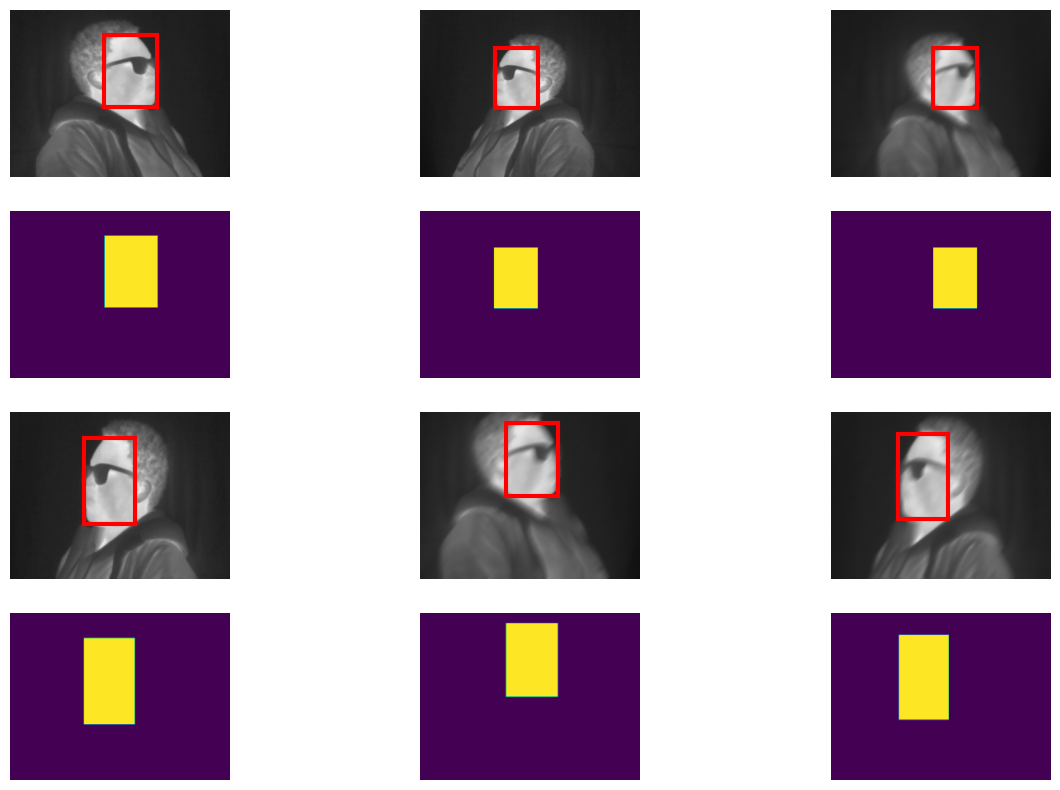

In [9]:
## Data Augmentation 
   
# Augmenters definition
random_crop = iaa.Crop(percent=(0, 0.2))
mirror = iaa.Fliplr(1.0)
random_blur = iaa.GaussianBlur(sigma=(0, 3.0))
random_noise = iaa.AdditiveGaussianNoise(scale=(10, 60))
motion_blur = iaa.MotionBlur(k=15, angle=[-45, 45])

# Define combinations
crop_and_blur = iaa.Sequential([random_crop, random_blur])
crop_and_mirror = iaa.Sequential([mirror, random_crop])
crop_and_motion_blur = iaa.Sequential([random_crop, motion_blur])
blur_and_noise = iaa.Sequential([random_blur, random_noise])
motion_and_noise = iaa.Sequential([motion_blur, random_noise])
crop_blur_noise = iaa.Sequential([random_crop, random_blur, random_noise])
crop_and_mirror_and_motion_blur = iaa.Sequential([random_crop, mirror, motion_blur])

# List of augmenters and their names
augmenters = [random_crop,
            mirror,
            motion_blur,
            crop_and_mirror,
            crop_and_motion_blur,
            crop_and_mirror_and_motion_blur]

# Combine augmented datasets to one super set
TrainAugDataset = train
ValAugDataset = val

def rectangle_from_coords(box, color='red'):
    box = np.array(box, dtype=np.float32)
    return plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], color=color, fill=False, lw=3)


n = np.random.randint(0, high = train.__len__())

plt.figure(figsize=(15, 10))
for i, aug in enumerate(augmenters):
    train_augmented = Tufts(images_path = "data/TD_IR_A", filelist = train_files, y_path = "data/bounding_boxes_update.csv", transform=t.Compose([t.ToTensor()]), augmenter=aug)
    val_augmented = Tufts(images_path = "data/TD_IR_A", filelist = val_files, y_path = "data/bounding_boxes_update.csv",transform=t.Compose([t.ToTensor()]), augmenter=aug)
    img, y, _,mask = train_augmented.__getitem__(n)
    if i < 3:
        
        plt.subplot(4, 3, i + 1)
        plt.imshow(img.permute(1,2,0))
        plt.gca().add_patch(rectangle_from_coords(y))
        plt.axis("off")

        plt.subplot(4, 3, i + 4)
        plt.imshow(mask)
        plt.axis("off")
    
    else:
        
        plt.subplot(4, 3, i + 4)
        plt.imshow(img.permute(1,2,0))
        plt.gca().add_patch(rectangle_from_coords(y))
        plt.axis("off")

        plt.subplot(4, 3, i + 7)
        plt.imshow(mask)
        plt.axis("off")
        
    TrainAugDataset = ConcatDataset([TrainAugDataset, train_augmented])
    ValAugDataset = ConcatDataset([ValAugDataset, val_augmented])

aug_train_loader =  DataLoader(TrainAugDataset, batch_size=batch_size, shuffle=True)
aug_val_loader =  DataLoader(ValAugDataset, batch_size=batch_size, shuffle=True)

In [33]:

# Training Loop
orient = True
orient_string = "orient" if orient else ""
model = BB_InceptionResnetV1(pretrained='vggface2', device = device)
best_model_params_path = os.path.join('models/', f'{model.__class__.__name__}_{orient_string}_{augment}_best_params.pt')
# model = load_model(model, best_model_params_path)

model.train()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

best_loss = 10
best_loss = 10 if not 'best_loss' in globals() else best_loss # Only assign new value to best_loss if its not defined

for e in tqdm(range(epochs), total = epochs):
        
    for mode in ["train"]:
        
        # Decide on DataLoader
        train_loader = aug_train_loader if train_augment else train_loader
        val_loader = aug_val_loader if val_augment else val_loader
        dataloader = train_loader if mode == "train" else val_loader
        model.train() if mode == "train" else model.eval()

        running_loss, running_bb, running_orient = 0, 0, 0

        for i, data in enumerate(dataloader):
          # Every data instance is an input + label pair
          img, bbox_true, orient_true, mask = data
          img, bbox_true, orient_true = img.to(device), bbox_true.to(device), orient_true.to(device)
          
          # Zero your gradients for every batch!
          optimizer.zero_grad()

          # Make predictions for this batch
          bbox_pred, orient_pred = model(img)

          #bb_loss = torchvision.ops.complete_box_iou_loss(bbox_pred, bbox_true.squeeze(), reduction = 'sum') * 2 # Double-weighted bbox loss
          bb_loss = F.l1_loss(bbox_pred, bbox_true.squeeze(), reduction = 'mean').sum()
          orient_loss = F.l1_loss(orient_pred.squeeze(), orient_true, reduction = 'mean')
          loss = bb_loss/5 + orient_loss if orient else bb_loss

          if mode == "train":
            loss.backward()
            optimizer.step()
          
          running_loss += loss
          running_bb += bb_loss
          running_orient += orient_loss

        epoch_loss = running_loss / len(tufts_a)
        epoch_bb = running_bb / len(tufts_a)
        epoch_orient = running_orient / len(tufts_a)

        scheduler.step()

        if e % 10 == 0:
            print(f"Epoch {e} {mode} - {epoch_loss}, with BBox Loss of {epoch_bb} and Orient Loss of {epoch_orient}")

        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), best_model_params_path)
            print(f'New best {model.__class__.__name__} saved')


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 train - 4.256704807281494, with BBox Loss of 17.59326934814453 and Orient Loss of 0.7380512952804565
New best BB_InceptionResnetV1 saved


  0%|          | 2/500 [04:16<17:47:25, 128.61s/it]

New best BB_InceptionResnetV1 saved


  1%|          | 3/500 [06:26<17:48:24, 128.98s/it]

New best BB_InceptionResnetV1 saved


  1%|          | 4/500 [08:36<17:48:41, 129.28s/it]

New best BB_InceptionResnetV1 saved


  1%|          | 5/500 [10:46<17:50:23, 129.74s/it]

New best BB_InceptionResnetV1 saved


  1%|          | 6/500 [12:57<17:50:27, 130.02s/it]

New best BB_InceptionResnetV1 saved


  1%|▏         | 7/500 [15:08<17:51:26, 130.40s/it]

New best BB_InceptionResnetV1 saved


  2%|▏         | 8/500 [17:14<17:38:19, 129.06s/it]

New best BB_InceptionResnetV1 saved


  2%|▏         | 9/500 [19:19<17:26:35, 127.89s/it]

New best BB_InceptionResnetV1 saved


  2%|▏         | 10/500 [21:23<17:13:44, 126.58s/it]

New best BB_InceptionResnetV1 saved


  2%|▏         | 11/500 [23:29<17:10:15, 126.41s/it]

Epoch 10 train - 2.342733383178711, with BBox Loss of 9.123007774353027 and Orient Loss of 0.5181339979171753


  2%|▏         | 12/500 [25:36<17:08:20, 126.44s/it]

New best BB_InceptionResnetV1 saved


  3%|▎         | 13/500 [27:43<17:07:56, 126.65s/it]

New best BB_InceptionResnetV1 saved


  3%|▎         | 14/500 [29:52<17:13:36, 127.61s/it]

New best BB_InceptionResnetV1 saved


  3%|▎         | 15/500 [32:03<17:18:45, 128.51s/it]

New best BB_InceptionResnetV1 saved


  4%|▎         | 18/500 [38:36<17:26:29, 130.27s/it]

New best BB_InceptionResnetV1 saved


  4%|▍         | 20/500 [42:57<17:22:04, 130.26s/it]

Epoch 20 train - 2.0265555381774902, with BBox Loss of 8.191023826599121 and Orient Loss of 0.3883523941040039


  4%|▍         | 21/500 [45:07<17:18:43, 130.11s/it]

New best BB_InceptionResnetV1 saved


  5%|▍         | 23/500 [49:28<17:15:04, 130.20s/it]

In [27]:

import matplotlib.patches as mpatches

def rectangle_from_coords(box, color='red'):
    box = np.array(box, dtype=np.float32)
    return plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], color=color, fill=False, lw=3)

def show_img_w_box(img, bb_true, bb_pred = None, orient = True, orient_pred = None):

    if device != "cpu":
        img, bb_true = img.cpu(), bb_true.cpu()
    
    plt.imshow(img.permute(1,2,0)[:,:,0], cmap = "plasma")
    plt.gca().add_patch(rectangle_from_coords(bb_true))

    if bb_pred is not None:
        bb_pred = bb_pred.cpu().detach() if device != "cpu" else bb_pred.detach()
        plt.gca().add_patch(rectangle_from_coords(bb_pred, color = "green"))

    if orient and orient_pred is not None:
        orient_pred = orient_pred.cpu().detach() if device != "cpu" else orient_pred.detach()

        midpoint_x = bb_pred[0] + 0.5*(bb_pred[2]-bb_pred[0])
        midpoint_y = bb_pred[1] + 0.5*(bb_pred[3]-bb_pred[1])


        plt.gca().add_patch(mpatches.FancyArrowPatch((midpoint_x, midpoint_y), (int(midpoint_x - (orient_pred * 30)), midpoint_y), color = "white", mutation_scale =  10))
        

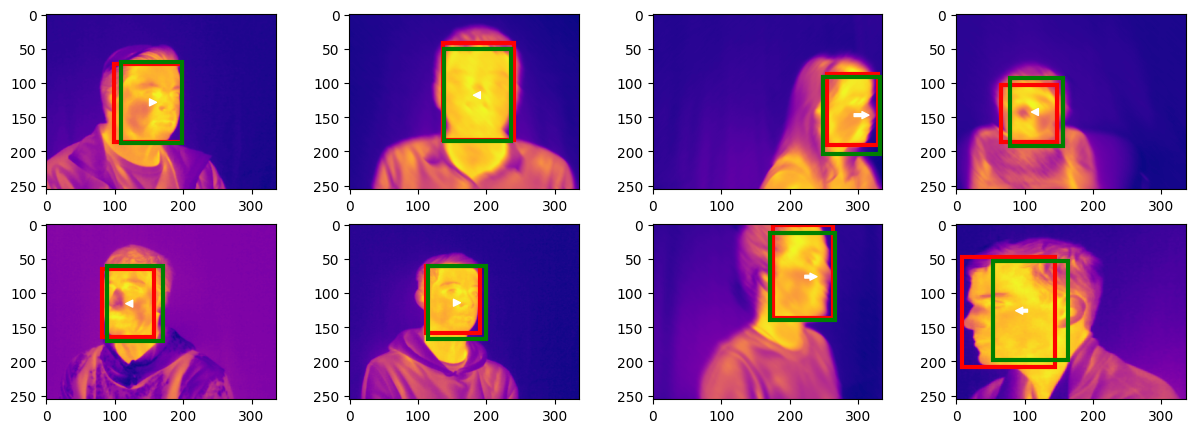

In [30]:

plt.figure(figsize=(15,5))
for i in range(batch_size):
    plt.subplot(int(batch_size // 4), 4, i+1)
    show_img_w_box(img[i], bbox_true[i], bbox_pred[i], orient_pred = orient_pred[i])


In [33]:

def load_model(model, best_model_params_path):
    try:
        try:
            model.load_state_dict(torch.load(best_model_params_path), strict = True)
            strict = "strictly"
        except:
            model.load_state_dict(torch.load(best_model_params_path), strict = False)
            strict = "unstrictly"
        print(f"Best {model.__class__.__name__} loaded {strict}")
    except:
        print(f"No {model.__class__.__name__} found at {best_model_params_path}")
    return(model)


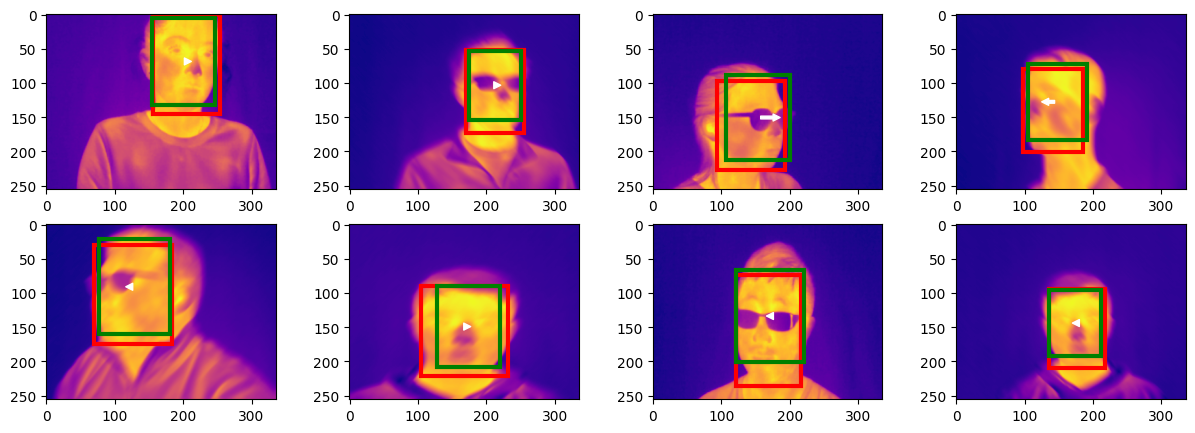

In [31]:
## test of TD_IR_E:

#model = load_model(BB_InceptionResnetV1(), best_model_params_path)
model.to(device)

img, bbox_true, orient_true, _ = next(iter(aug_val_loader))
img, bbox_true, orient_true = img.to(device), bbox_true.to(device), orient_true.to(device)
bbox_pred, orient_pred = model(img)

plt.figure(figsize=(15,5))
for i in range(batch_size):
    plt.subplot(int(batch_size // 4),4, i+1)
    show_img_w_box(img[i], bbox_true[i], bbox_pred[i], orient_pred = orient_pred[i])


Best BB_InceptionResnetV1 loaded unstrictly


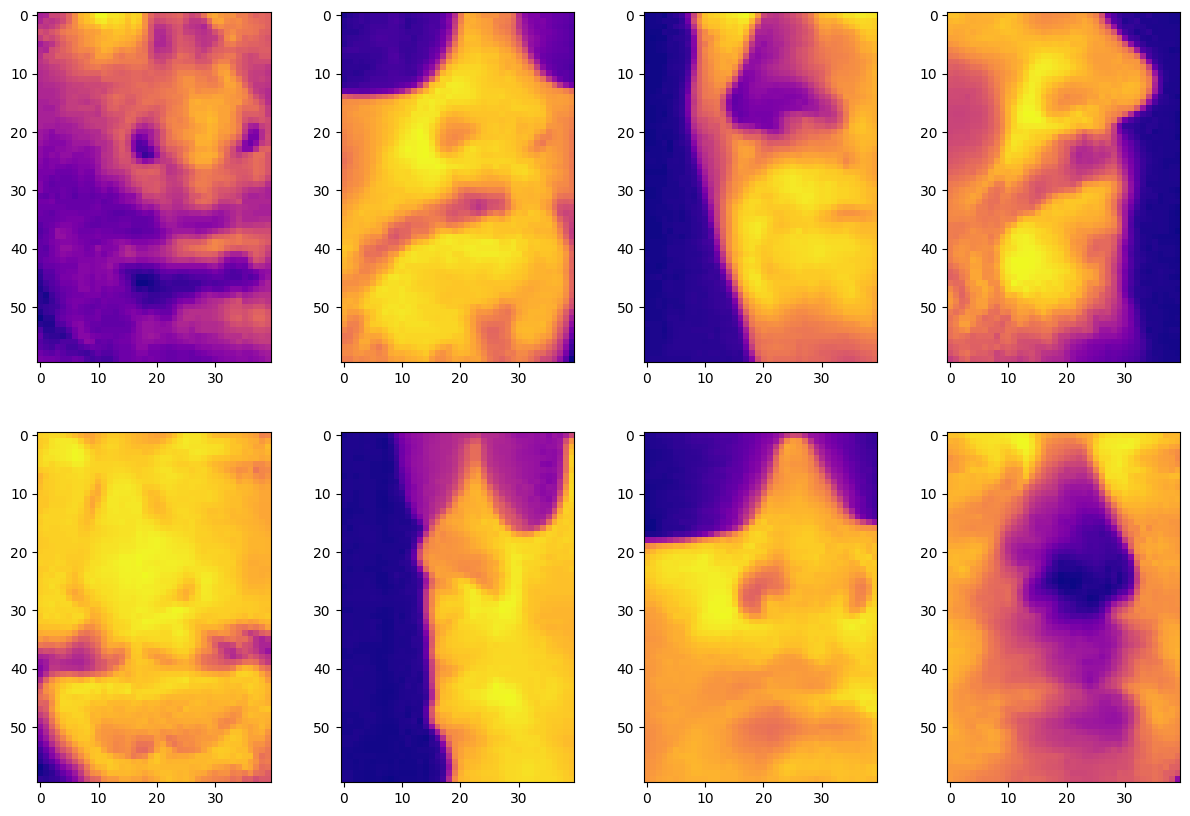

In [61]:
### ROI identification

## Idea: Annotate whether person looks to left or right. Like this, the ROI can manually be cropped from image
# Head orientation can be learned via a fifth output node, with strong positive values indicating left orientation and strong negative values indicating right orientation
# Based on the prediction of the Network, the ROI can then be dynamically cropped.with 0 indicating a center crop, a negative value indicating a crop to the right of the image (where Nose points), and a positive value indicating a crop to the left.

# Load Model and predict boxes
loader = a_loader
model = load_model(BB_InceptionResnetV1(), best_model_params_path)
model.to(device)

img, bbox_true, orient_true = next(iter(loader))
img, bbox_true, orient_true = img.to(device), bbox_true.to(device), orient_true.to(device)
bbox_pred, orient_pred = model(img)

plt.figure(figsize=(15,10))
for i in range(batch_size):
    plt.subplot(int(batch_size // 4), 4, i+1)
    image, box, orient = img[i].cpu().detach(), bbox_pred[i].cpu().detach(), orient_pred[i].cpu().detach()

    midpoint_x = int(box[0] + 0.5*(box[2]-box[0])  - orient*30)
    midpoint_y = int(box[1] + 0.5*(box[3]-box[1]))

    box_width_height = 20
    x_border_left = midpoint_x - box_width_height
    x_border_right = midpoint_x + box_width_height
    y_border_down = midpoint_y - box_width_height 
    y_border_up = midpoint_y + box_width_height + 20 
    
    plt.imshow(image[:,y_border_down:y_border_up,x_border_left:x_border_right].permute(1,2,0)[:,:,0], cmap = 'plasma')



AssertionError: X Dimension = 0

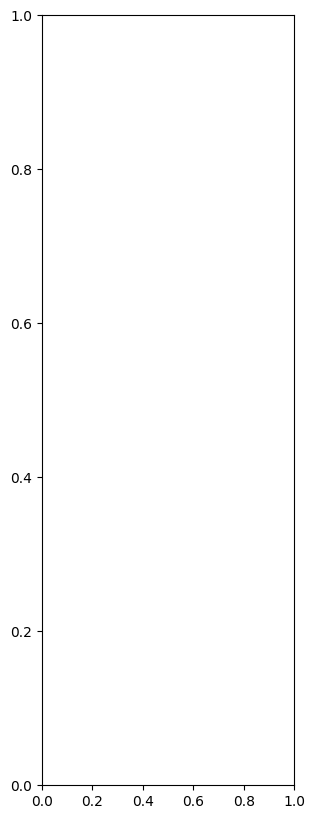

In [392]:
# Data Augmentation

def create_mask(bb, x):
    """Creates a mask for the bounding box of same shape as image"""
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int32)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y

def mask_to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

def create_bb_array(x):
    """Generates bounding box array from a train_df row"""
    return np.array([x[5],x[4],x[7],x[6]])


# modified from fast.ai
def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = np.random.uniform(0, 1)
    rand_c = np.random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    assert r != 0, "r Dimension = 0"
    assert c != 0, "r Dimension = 0"
    c_pix = round(r_pix*c/r)
    rand_r = np.random.uniform(0, 1)
    rand_c = np.random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    assert xx.shape[0] != 0, "X Dimension = 0"
    assert YY.shape[0] != 0, "Y Dimension = 0"
    return xx, YY

def transformsXY(img, bb, transforms = True):
    x = img.cpu().numpy()
    bb = bb.cpu().numpy()
    Y = create_mask(bb, x)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

device = "cuda:0"
img, bbox_true, orient_true = next(iter(e_loader))
img, bbox_true, orient_true = img.to(device), bbox_true.to(device), orient_true.to(device)
bbox_pred, orient_pred = model(img)

device = "cpu"
plt.figure(figsize=(15,10))
for i in range(batch_size):
    plt.subplot(int(batch_size // 4),4, i+1)
    trans_im, trans_bb = transformsXY(img[i], bbox_true[i])
    trans_im, trans_bb = torch.tensor(trans_im), torch.tensor(trans_bb)
    show_img_w_box(trans_im, trans_bb)


In [390]:
import imgaug.augmenters as iaa

image = cv2.imread(self.image_paths[idx])
mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

if self.augmenter:

    if not isinstance(self.augmenter, list):
        self.augmenter = [self.augmenter]

    seed = None
    for aug in self.augmenter:
        if isinstance(aug, (iaa.Crop, iaa.Fliplr)):
            if seed is None:
                seed = aug.to_deterministic()
            image = seed.augment_image(image)
            mask = seed.augment_image(mask)
        else:
            image = aug.augment_image(image)

torch.Size([3, 256, 336])

In [425]:
image

In [456]:
img, bbox_true, orient_true = next(iter(a_loader))
img, bbox_true, orient_true = img.to(device), bbox_true.to(device), orient_true.to(device)
bbox_pred, orient_pred = model(img)

In [498]:
batch_size = 8